# Constrained Active Learning - Experiment on the PascalPart Object Recognition problem

#### Importing libraries

In [2]:
#%matplotlib inline
#%autosave 10
import os
import random

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import trange
import torch.multiprocessing

from active_learn_strategy import SUPERVISED, CAL, UNCERTAIN, RANDOM, supervised_selection, random_selection, \
	cal_selection, uncertainty_selection, \
	uncertainty_loss
from constraint_loss import pascalpart_loss
from metrics import F1
from pascalpart import PascalPartDataset, name_list, name_ids
from vision_utils import my_utils, utils
from vision_utils.my_model import my_fasterrcnn_resnet50_fpn, MyFasterRCNN
from vision_utils.engine import evaluate, train_one_epoch

torch.multiprocessing.set_sharing_strategy('file_system')
plt.rc('animation', html='jshtml')
sns.set_theme(style="whitegrid", font="Times New Roman")

dataset = "pascalpart"
model_folder = os.path.join("models", dataset)
result_folder = os.path.join("results", dataset)
image_folder = os.path.join("images", dataset)
if not os.path.isdir(model_folder):
	os.makedirs(model_folder)
if not os.path.isdir(result_folder):
	os.makedirs(result_folder)
if not os.path.isdir(image_folder):
	os.makedirs(image_folder)

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
dev = "cuda:1" if torch.cuda.is_available() else "cpu"
dev

'cuda:1'

#### Loading data to create the PascalPart dataset and setting

In [3]:
dataset = PascalPartDataset('data/PascalPart',
							my_utils.get_transform(train=True), load=True)
data_loader = DataLoader(dataset, batch_size=2, num_workers=4,
						 shuffle=True, collate_fn=utils.collate_fn)
class_names = name_list
class_names

Targets loaded


array(['0-background', 'aeroplane', 'aeroplane_body', 'arm', 'backside',
       'beak', 'bicycle', 'bird', 'boat', 'body', 'bottle', 'bottle_body',
       'bus', 'cap', 'car', 'cat', 'chainwheel', 'chair', 'coach', 'cow',
       'dog', 'door', 'ear', 'ebrow', 'engine', 'eye', 'foot',
       'frontside', 'hair', 'hand', 'handlebar', 'head', 'headlight',
       'hoof', 'horn', 'horse', 'leftside', 'leg', 'mirror', 'motorbike',
       'mouth', 'muzzle', 'neck', 'nose', 'paw', 'person', 'plant',
       'plate', 'pot', 'pottedplant', 'rightside', 'roofside', 'saddle',
       'screen', 'sheep', 'sofa', 'stern', 'table', 'tail', 'torso',
       'train', 'train_head', 'tvmonitor', 'wheel', 'window', 'wing'],
      dtype='<U14')

#### Visualizing a sample training data with the corresponding bounding boxes

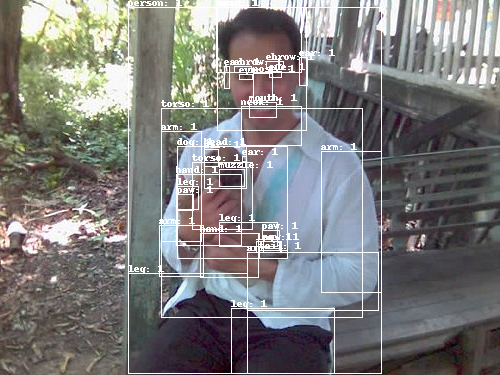

In [4]:
image, target = dataset[10]
im = my_utils.visualize_boxes(image, target, name_list, show=False)
im

#### Setting some hyperparameters for the active learning strategies

In [5]:
seeds = range(3)
first_points = 100
n_points = 50
n_iterations = 18
epochs = 50
tot_points = len(dataset)
num_classes = len(name_ids)
num_classes

66

#### Defining constraints as product t-norm of the FOL rule expressing by the structured knowledge of PascalPart classes
In order to calculate the t-norm we first need to convert the detection results to a class-wise multi-label prediction.
Notice: some data even in the dataset may slightly violate the constraints

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


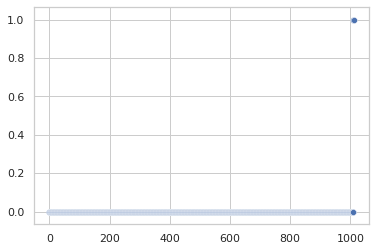

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [6]:
def calculate_constraint_loss(f: torch.Tensor, reduce_sum=False) -> torch.Tensor:
	c_loss = pascalpart_loss(f, sum=reduce_sum)
	return c_loss

def convert_detection_to_prediction(detections: list):
	preds = torch.zeros((len(detections), num_classes))
	for i, target in enumerate(detections):
		for label in range(num_classes):
			predicted_class = target['labels'] == label
			# check if the class has been predicted at least once
			if predicted_class.any():
				if 'scores' in target:
					score = torch.max(target['scores'][predicted_class])
				else:
					score = 1
				# we take out background class 0
				preds[i, label - 1] = score
	return preds

targets = []
for i, data in enumerate(data_loader):
	targets.extend([*data[1]])
	if i == len(data_loader) // 10:
		break

predictions = convert_detection_to_prediction(targets)
cons_loss = calculate_constraint_loss(predictions).sort()[0].cpu().numpy()
sns.scatterplot(x=[*range(len(cons_loss))], y=cons_loss)
plt.show()
predictions

#### Creating the model (Faster RCNN with Resnet50 backbone pretrained on COCO)

In [7]:
def get_instance_segmentation_model(n_classes):
	net = my_fasterrcnn_resnet50_fpn(pretrained=True)
	# net = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

	# get the number of input features for the classifier
	in_features = net.roi_heads.box_predictor.cls_score.in_features
	# replace the pre-trained head with a new one
	net.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)

	return net

#### Checking outputs before training

In [ ]:
def visualize_data_predictions(net: MyFasterRCNN, d_loader: DataLoader,
                               idx: list = None) -> float:
	acc, detects, s_loss = evaluate(net, d_loader, dev)
	p_t = convert_detection_to_prediction(detects)

	c_loss = calculate_constraint_loss(p_t).cpu()
	if idx is None:
		u_idx = np.asarray([*range(tot_points)])
	else:
		u_idx = np.zeros_like(s_loss)
		u_idx[idx] = 1
	sns.scatterplot(x=c_loss, y=s_loss, style=u_idx)
	plt.title("Supervision vs Constraint Loss")
	plt.show()
	print(f"mAP: {map}, Loss: {s_loss.mean().item()}")
	return acc


#### Few epochs with n randomly selected data

In [ ]:
def train_loop(net: MyFasterRCNN, train_data: PascalPartDataset,
               train_idx: list, eps: int, visualize_loss: bool = False):
	train_idx = np.asarray(train_idx)
	train_data = torch.utils.data.Subset(train_data, train_idx)
	data_loader = DataLoader(dataset, batch_size=2, num_workers=4,
							 shuffle=True, collate_fn=utils.collate_fn)
	net.to(dev)

	params = [p for p in net.parameters() if p.requires_grad]
	optim = torch.optim.SGD(params, lr=0.005,
							momentum=0.9, weight_decay=0.0005)

	# and a learning rate scheduler which decreases the learning rate by
	lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5,
												   gamma=0.1)
	l_train = []
	for j in range(eps):
		metrics = train_one_epoch(net, optim, data_loader, dev,
								  j, print_freq=10, verbose=True)
		s_l = metrics.meters['loss'].global_avg
		l_train.append(s_l.item())

	if visualize_loss:
		sns.lineplot(data=l_train)
		plt.ylabel("Loss"), plt.xlabel("Epochs"), plt.yscale("log")
		plt.title("Training loss variations in function of the epochs")
		plt.show()
	return l_train


first_idx = [[] * seeds]
first_loss = []
first_acc = []
for seed in seeds:
	network = get_instance_segmentation_model(num_classes).to(dev)
	first_idx[seed] += np.random.randint(0, tot_points, first_points).tolist()
	first_loss.append(train_loop(network, dataset, first_idx[seed], epochs, visualize_loss=True))
	first_acc.append(visualize_data_predictions(network, data_loader, first_idx[seed]))
	torch.save(network, os.path.join(model_folder, f"first_train_{seed}.pt"))

In [ ]:
strategies = [RANDOM, SUPERVISED, CAL, UNCERTAIN]
selection_fun = {
	SUPERVISED: supervised_selection,
	RANDOM: random_selection,
	CAL: cal_selection,
	UNCERTAIN: uncertainty_selection,
}
df = {
	"strategy": [],
	"seed": [],
	"iteration": [],
	"active_idx": [],
	"used_idx": [],
	"predictions": [],
	"accuracy": [],
	"supervision_loss": [],
	"constraint_loss": [],
	"uncertainty_loss": []
}
for seed in seeds:

	for strategy in strategies:
		# Loading weights saved after first training
		network = torch.load(os.path.join(model_folder, f"first_train_{seed}.pt")).to(dev)
		with torch.no_grad():
			preds_t = network(x_t).squeeze()
		accuracy = metric(preds_t, y_multi_t)
		assert first_acc[seed] == accuracy, "Error in loading the network"
		cons_loss = calculate_constraint_loss(preds_t)
		sup_loss = torch.nn.BCELoss(reduction="none")(preds_t, y_multi_t).sum(dim=1)
		unc_loss = uncertainty_loss(preds_t)

		active_accuracies = [accuracy]
		available_idx = [*range(tot_points)]
		used_idx: list = first_idx[seed].copy()

		df["strategy"].append(strategy)
		df["seed"].append(seed)
		df["iteration"].append(0)
		df["active_idx"].append(used_idx.copy())
		df["used_idx"].append(used_idx.copy())
		df["predictions"].append(preds_t.cpu().numpy())
		df["accuracy"].append(accuracy)
		df["constraint_loss"].append(cons_loss.cpu().numpy())
		df["supervision_loss"].append(sup_loss.cpu().numpy())
		df["uncertainty_loss"].append(unc_loss.cpu().numpy())

		losses = first_loss[seed].copy()
		pbar = trange(n_iterations, ncols=100)
		for n in range(1, n_iterations + 1):
			available_idx = list(set(available_idx) - set(used_idx))

			if strategy == SUPERVISED:
				active_idx = supervised_selection(used_idx, sup_loss, n_points)
			elif strategy == CAL:
				active_idx = cal_selection(used_idx, cons_loss, n_points)
			elif strategy == UNCERTAIN:
				active_idx = uncertainty_selection(used_idx, unc_loss, n_points)
			else:
				active_idx = random_selection(available_idx, n_points)
			used_idx += active_idx

			losses += train_loop(network, x_t, y_multi_t, used_idx, epochs)

			with torch.no_grad():
				preds_t = network(x_t).squeeze()
			accuracy = metric(preds_t, y_multi_t)
			cons_loss = calculate_constraint_loss(preds_t)
			sup_loss = torch.nn.BCELoss(reduction="none")(preds_t, y_multi_t).sum(dim=1)
			unc_loss = uncertainty_loss(preds_t)

			df["strategy"].append(strategy)
			df["seed"].append(seed)
			df["iteration"].append(n)
			df["active_idx"].append(active_idx.copy())
			df["used_idx"].append(used_idx.copy())
			df["predictions"].append(preds_t.cpu().numpy())
			df["accuracy"].append(accuracy)
			df["constraint_loss"].append(cons_loss.cpu().numpy())
			df["supervision_loss"].append(sup_loss.cpu().numpy())
			df["uncertainty_loss"].append(unc_loss.cpu().numpy())
			pbar.set_description(f"Seed: {seed}/{len(seeds)}, Strategy: {strategy}, "
			                     f"Acc: {accuracy:.1f}, S loss: {sup_loss.mean().item():.2f}, n p: {len(used_idx)}")
			pbar.update()

		pbar.close()
		if seed == 0:
			sns.lineplot(data=losses)
			plt.yscale("log")
			plt.ylabel("Loss")
			plt.xlabel("Epochs")
			plt.title(f"Training loss variations for {strategy} active learning strategy")
			plt.show()

df = pd.DataFrame(df)
df.to_pickle(os.path.join(result_folder, f"metrics_{n_points}_points.pkl"))

In [ ]:
np.asarray(used_idx)

In [ ]:
df = pd.read_pickle(os.path.join(result_folder, f"metrics_{n_points}_points.pkl"))
df['n_points'] = [len(used) for used in df['used_idx']]
sns.lineplot(data=df, x="n_points", y="accuracy", hue="strategy", ci=75)
plt.ylabel("Accuracy")
plt.xlabel("Number of points used")
plt.title("Comparison of the accuracies in the various strategy in function of the iterations")
plt.savefig(os.path.join(image_folder, f"Accuracy_{n_points}_points.png"))
plt.show()


#### Create animation to visualize training

In [ ]:
def animate_points_and_prediction(i, active_strategy, dataframe):
	print(i)
	dataframe = dataframe[dataframe["seed"] == 0]
	df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
	if i != len(df_strategy["active_idx"]):
		a_idx = df_strategy["active_idx"][i]
		u_idx = df_strategy["used_idx"][i]
	else:
		a_idx = []
		u_idx = df_strategy["used_idx"][i - 1]
	new_idx = [1 if idx in a_idx else 0 for idx in u_idx]
	x0, x1 = x[:, 0], x[:, 1]
	if i == 0:
		preds = df_strategy["predictions"][i]
	else:
		preds = df_strategy["predictions"][i - 1]
	sns.scatterplot(x=x0, y=x1, hue=preds, legend=False)
	sns.scatterplot(x=x0[np.asarray(u_idx)], y=x1[np.asarray(u_idx)],
	                hue=new_idx, legend=False)
	plt.axhline(0.5, 0, 1, c="k")
	plt.axvline(0.5, 0, 1, c="k")
	plt.title(f"Selected data points for {strategy} training, iter {i}")


def animate_cons_loss(i, active_strategy, dataframe):
	df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
	cons_loss = df_strategy["constraint_loss"][i]
	x0, x1 = x[:, 0], x[:, 1]
	sns.scatterplot(x=x0, y=x1, hue=cons_loss, legend=False)


def animate_sup_loss(i, active_strategy, dataframe):
	df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
	sup_loss = df_strategy["supervision_loss"][i]
	x0, x1 = x[:, 0], x[:, 1]
	sns.scatterplot(x=x0, y=x1, hue=sup_loss, legend=False)


#### Displaying the animations

In [ ]:
writer = matplotlib.animation.FFMpegWriter(fps=1)
strategy = SUPERVISED
fig = plt.figure()
ani_sup = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                             frames=n_iterations + 1, fargs=[strategy, df])
ani_sup.save(os.path.join(image_folder, f"{strategy}_point_selection_{n_points}_points.mp4"), writer=writer)

In [ ]:
ani_sup

In [ ]:
strategy = CAL
fig = plt.figure()
ani_cal = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                             frames=n_iterations + 1, fargs=[strategy, df])
ani_cal.save(os.path.join(image_folder, f"{strategy}_point_selection_{n_points}_points.mp4"), writer=writer)

In [ ]:
ani_cal

In [ ]:
strategy = UNCERTAIN
fig = plt.figure()
ani_unc = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                             frames=n_iterations + 1, fargs=[strategy, df])
ani_unc.save(os.path.join(image_folder, f"{strategy}_point_selection_{n_points}_points.mp4"), writer=writer)

In [ ]:
ani_unc

In [ ]:
writer = matplotlib.animation.FFMpegWriter(fps=1)
strategy = RANDOM
fig = plt.figure()
ani_rand = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                              frames=n_iterations + 1, repeat=True, fargs=[strategy, df])
ani_rand.save(os.path.join(image_folder, f"{strategy}_point_selection_{n_points}_points.mp4"), writer=writer)

In [ ]:
ani_rand